# Intro:
Artificial Intelligence (AI) is everywhere. Machine Learning and AI are completely revolutionizing the way modern problems are solved. One of the cool ways to apply Machine Learning is by using financial data. Finance data is a playground for Machine Learning.

In this project, I analyze Tesla closing stock prices using Support Vector Regression with sci-kit-learn and an LSTM using Keras. This is my second Machine Learning project and I have continued to learn massive amounts of information about Machine Learning and Data Science. If you enjoy this check out my other project where I created a Convolutional Neural Network to recognize images of Nicolas Cage.

When analyzing financial data with techniques like LSTM's and other algorithms, it's important to keep in mind that these are not guaranteed results. The stock market is incredibly unpredictable and rapidly changing. This was just a fun project to learn the techniques that go into stock analysis using neural networks. This is not an article claiming that this technology will make you millions because it absolutely won't. 

In [15]:
import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import pandas as pd 
import pandas_datareader.data as web
import datetime
import numpy as np 
from matplotlib import style

# ignore warnings 
import warnings
warnings.filterwarnings('ignore')

## Imports:
Here we import: 
* Keras to create our neural network
* pandas and pandas_data reader to get and analyze our stock data
* datetime to fix our stock dates for data analysis 
* numpy to reshape our data to feed into our neural network 
* matplotlib to plot and visualize our data 
* warnings to ignore any of the unwanted warnings that pop up 

In [16]:
# Get the stock data using yahoo API:
style.use('ggplot')

# get 2014-2018 data to train our model
start = datetime.datetime(2014,1,1)
end = datetime.datetime(2018,12,30)
df = web.DataReader("TSLA", 'yahoo', start, end) 

# get 2019 data to test our model on 
start = datetime.datetime(2019,1,1)
end = datetime.date.today()
test_df = web.DataReader("TSLA", 'yahoo', start, end) 

## Getting our stock data: 
* This code changes our plot style to ggplot. I changed the style to ggplot because I like the look of it. Read more about ggplot [here](https://matplotlib.org/3.1.1/gallery/style_sheets/ggplot.html). 
* We then use pandas_datareader as "web" to get our stock price data using the DataReader function which gets the finance data and stores it in a pandas dataframe. 
* We get the Tesla stock data from 2014-2018 to train our model on. 
* We get the Tesla stock data from 2019 to the current day to have our model make predictions on.
* "TSLA" is the stock ticker symbol for Tesla and we specify 'yahoo' to get the data using the Yahoo finance API.

In [17]:
# sort by date
df = df.sort_values('Date')
test_df = test_df.sort_values('Date')

# fix the date 
df.reset_index(inplace=True)
df.set_index("Date", inplace=True)
test_df.reset_index(inplace=True)
test_df.set_index("Date", inplace=True)

df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-12-24,314.500000,295.200012,313.500000,295.390015,5559900,295.390015
2018-12-26,326.970001,294.089996,300.000000,326.089996,8163100,326.089996
2018-12-27,322.170013,301.500000,319.839996,316.130005,8575100,316.130005
2018-12-28,336.239990,318.410004,323.100006,333.869995,9939000,333.869995
2018-12-31,339.209991,325.260010,337.790009,332.799988,6302300,332.799988


## Fixing our data:
* Since we are doing a time series prediction we want our data to be sequential. We sort our train and test data by date. 
* We then reset the index and set the index of our dataframe to make sure the dates of our stock prices are a column in our dataframe 

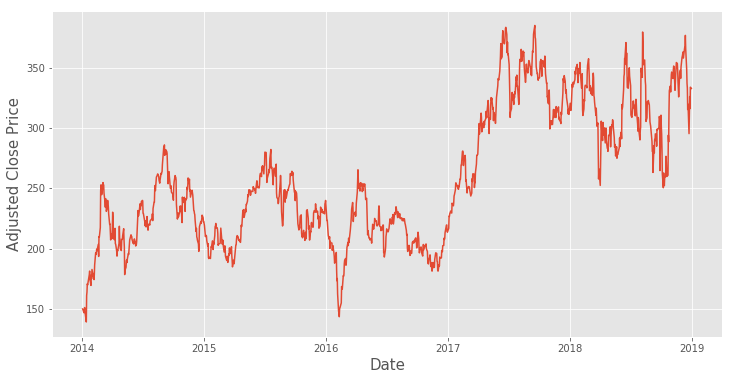

In [18]:
# Visualize the training stock data:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (12,6))
plt.plot(df["Adj Close"])
plt.xlabel('Date',fontsize=15)
plt.ylabel('Adjusted Close Price',fontsize=15)
plt.show()

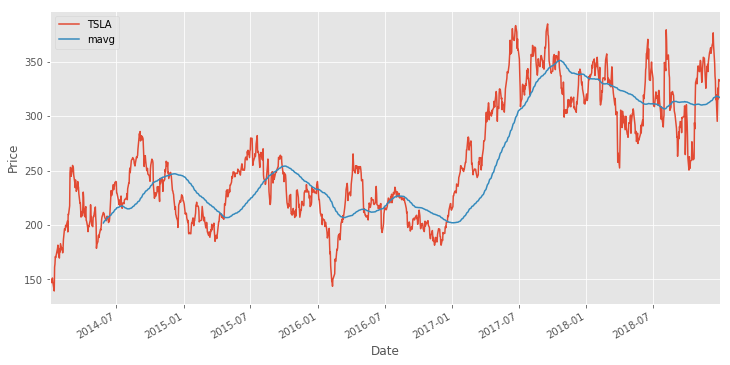

In [19]:
# Rolling mean
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

plt.figure(figsize = (12,6))
close_px.plot(label='TSLA')
mavg.plot(label='mavg')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

## Rolling mean: 
* We get our adjusted closing prices from our dataframe and we plot a rolling mean on our data. 
* Rolling mean is also called moving average. Moving average helps us smooth out data that has lots of fluctuations and helps us better see the long term trend of the data.
* With moving average you can define a period of time you'd like to take the average of which is known as our window. We define our moving average window to be 100. We define 100 because we want to see the moving average over the long term in our data. 

#### The math: 
* The way moving average works is it sums the prices of 100 days in a row and divides by 100 to get the mean. Then we move our window to the right by one. So we drop the first price and add a new price to the end. 
* Another way to think of it is think of it as an array of 100 prices. We sum all the elements and divide by 100 to get our average. We then remove the element at ```a[0]``` append another price to the end of the array. We then sum all the elements again and then divide by 100 to get our next average point. 

In [20]:
import matplotlib.dates as mdates

# change the dates into ints for training 
dates_df = df.copy()
dates_df = dates_df.reset_index()

# Store the original dates for plotting the predicitons
org_dates = dates_df['Date']

# convert to ints
dates_df['Date'] = dates_df['Date'].map(mdates.date2num)

dates_df.tail()

,Date,High,Low,Open,Close,Volume,Adj Close
1253,737052.0,314.500000,295.200012,313.500000,295.390015,5559900,295.390015
1254,737054.0,326.970001,294.089996,300.000000,326.089996,8163100,326.089996
1255,737055.0,322.170013,301.500000,319.839996,316.130005,8575100,316.130005
1256,737056.0,336.239990,318.410004,323.100006,333.869995,9939000,333.869995
1257,737059.0,339.209991,325.260010,337.790009,332.799988,6302300,332.799988


## Converting dates: 
* Here we create a copy of our dataframe and called it dates_df. We store our original dates in org_dates. We will use org_dates later to plot our predictions and dates. 
* We then convert our dates_df dates to integers by using mdates.date2num. We need the dates as integers because you can't feed dates into Support Vector Machines and neural networks. 

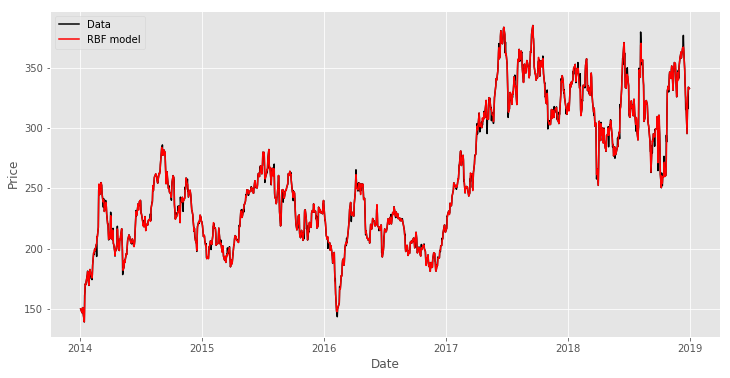

In [21]:
# Use sklearn support vector regression to predicit our data:
from sklearn.svm import SVR

dates = dates_df['Date'].as_matrix()
prices = df['Adj Close'].as_matrix()

#Convert to 1d Vector
dates = np.reshape(dates, (len(dates), 1))
prices = np.reshape(prices, (len(prices), 1))

svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
svr_rbf.fit(dates, prices)

plt.figure(figsize = (12,6))
plt.plot(dates, prices, color= 'black', label= 'Data')
plt.plot(org_dates, svr_rbf.predict(dates), color= 'red', label= 'RBF model') 
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Support Vector Regression: 
* In this code we use Sklearn and Support Vector Regression (SVR) to predict the prices on our data. 
* We get our adjusted close prices and dates as integers from our data. We reshape the data into 1D vectors since we need to feed the data into the SVR. 

### Understanding the pieces: 
#### Linear Regression 
* Linear Regression is a way to find the best linear relationship or line of best fit between two variables. 
* With a line of best fit given a dependent variable (x), we could predict our independent variable (y).
* The goal of linear regression is to find the line of best fit for our data that will result in the predicted y's to be as close to our known y values we give it. Below is a helpful image of the equation for linear regression:

<img src="Images/regression_eq.png">

* Also a helpful image of what linear regression looks like graphically: 
<img src="Images/regression_graph.png">

* So regression tries to learn the best A and B values for our data by minimizing a cost function. The cost function usually used for linear regression is mean squared error (MSE). Below is the equation for MSE: 

<img src="Images/MSE_eq.png">

* The way this cost function is minimized is using a process called gradient descent. I won't explain that here but if you want to see my explanation, check out my Nicolas Cage Convolutional Neural Network [project](https://medium.com/p/my-first-contribution-to-data-science-a-convolutional-neural-network-that-recognizes-images-of-fdf9b01c6925).


So in our case, we would be trying to find a line of best fit between the dates and our prices of stocks. Since our data has so many fluctuations, there is no line of best fit that could be used with linear regression to give us a good accuracy on stock predictions. So using solely linear regression would not be accurate in our case. Data with a linear relationship like predicting a house price based on how big the house is would be an example of linear data. 

#### Support Vector Machine: 
* Support Vector Machines (SVMs) are used for classification. The goal of an SVM is to define a boundary line between the 2 classes on a graph. We can think of this as "splitting" the data in the best possible way. This boundary line is called a hyperplane.
* The hyperplane in an SVM has a "margin" or distance between the 2 classes. These 2 lines that make up the margin are the distance from the hyperplane to the closest data example in each class. These lines are called boundary lines.
* After the splitting process is completed, a SVM can predict which class a singular data point should belong to based on its position on the graph. Below is a helpful graph to help visualize:

<img src="Images/SVM_graph.png">

* As you can see we have the optimal hyperplane in the middle and then two dotted lines as our boundary lines that go through the closest data point in each class. 
* When determining boundary lines with a SVM, we want the margin to be the widest possible distance between the 2 classes. This will help the SVM generalize when it sees new data that it needs to classify. 

### Putting it all together: 
* Now that we have a basic understanding of Linear Regression and SVMs, SVR is the combination of a Support Vector Machines and Regression. 
* Linear Regression won't work on our data because our data has many fluctuations and a linear line of best fit would give poor predictions on stock data. A SVM will not work on our data because we aren't classifying between two different classes. 
* With stock data, we are not predicting a class, we are predicting the next value in a series.
* Using regression we try to minimize the cost function using something like gradient descent. With SVMs we try to try to draw a hyperplane between 2 different classes. So SVR is the combo of the 2, we try to minimize the error within a certain threshold. Below is an amazing image from a helpful [article](https://medium.com/coinmonks/support-vector-regression-or-svr-8eb3acf6d0ff) on SVR to help visualize SVR: 

<img src="Images/SVR_graph.png">

* The blue line is our hyperplane and the red lines are our boundary lines. I hope you can start to see how we are combining the ideas of support vector machines and regression. We are trying to predict values accurately within a certain threshold. 
* So we define our boundary lines to make up our margin as +eplison and -eplison. Eplison is the distance from our hyperplane to each boundary line. 
* We can then define our regression line as y=wx+b 
* Our goal is to minimize the error and maximize the margin distance. 
* The cool thing about SVR is it can be applied to predict values within a nonlinear threshold. Below is a helpful image to visualize what SVR looks like: 

<img src="Images/SVR_5.png">


### The code: 
* Using sklearn we define our SVR 
* A kernel is a function to map lower-dimensional data into higher dimensional data. We define our kernel to be RBF. RBF stands for radial basis function. The equation for RBF is below: 

<img src="Images/rbf.png">

* This is the kernel function equation for RBF. RBF transfers our 2D space into a higher dimension to help better fit our data. The function takes the squared euclidean distance between 2 samples and divides by some sigma value. The value of sigma determines how "tight" our curve fits or data. 
* To help better understand how RBF transfers our data to higher-dimensional space, I created a gif from this [video](https://www.youtube.com/watch?v=-Z4aojJ-pdg) from Brandon Rohrer. This shows how a linear hyperplane fails to separate the 4 sets of data points. So we use a kernel function to convert our data to a higher dimension and "stretch" our data space to fit our data points into categories: 

![kernel.gif](Images/kernel.gif)

* C is the regularization parameter. This is how much you want to avoid misclassifying each training example.
* For large values of C, the algorithm will choose a smaller-margin hyperplane. 
* For small values of C, the algorithm will look for a large margin separating the hyperplane even if that means misclassifying some points. Below is a helpful image to visualize the differences between the size of C values. 

<img src="Images/SVM_Cvals.png">

* In our case we choose our C value to be 1e3 which is a large value for C which means our algorithm will choose a smaller-margin hyperplane.
* According to the sklearn [documentation](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html), "The gamma parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’." 
* So in other words high gamma only points nearby the boundary lines are taken into consideration when deciding on the place of the hyperplane. And with low gamma points that are close and far from the boundary lines are taken into consideration when deciding on the place of the hyperplane. Below is another helpful picture to visualize: 

<img src="Images/high_g.png" width = 400 height = 400>
<img src="Images/low_g.png" width = 400 height = 400>

In [22]:
# Create train set of adj close prices data:
train_data = df.loc[:,'Adj Close'].as_matrix()
print(train_data.shape) # 1258 

(1258,)


In [23]:
# Apply normalization before feeding to LSTM using sklearn:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)

scaler.fit(train_data)
train_data = scaler.transform(train_data)

## Normalizing: 
* Here we create our training data and normalize it. We use sklearn to create a MinMaxScaler() object. 
* MinMaxScaler works by shrinking the range of our values into 0 or 1 
* Below is the equation for min-max scaler: 
<img src="Images/MinMax.png">
* This is the equation that sklearn is doing in the background to convert our data into our desired range. 

In [24]:
'''Function to create a dataset to feed into an LSTM'''
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [25]:
# Create the data to train our model on:
time_steps = 36
X_train, y_train = create_dataset(train_data, time_steps)

# reshape it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 36, 1))

print(X_train.shape)

(1222, 36, 1)


In [26]:
# Visualizing our data with prints: 
print('X_train:')
print(str(scaler.inverse_transform(X_train[0])))
print("\n")
print('y_train: ' + str(scaler.inverse_transform(y_train[0].reshape(-1,1)))+'\n')

X_train:
[[150.1000061 ]
 [149.55999756]
 [147.        ]
 [149.36000061]
 [151.27999878]
 [147.52999878]
 [145.72000122]
 [139.33999634]
 [161.27000427]
 [164.13000488]
 [170.97000122]
 [170.00999451]
 [176.67999268]
 [178.55999756]
 [181.5       ]
 [174.6000061 ]
 [169.61999512]
 [178.38000488]
 [175.22999573]
 [182.83999634]
 [181.41000366]
 [177.11000061]
 [178.72999573]
 [174.41999817]
 [178.38000488]
 [186.52999878]
 [196.55999756]
 [196.61999512]
 [195.32000732]
 [199.63000488]
 [198.22999573]
 [203.69999695]
 [193.63999939]
 [209.97000122]
 [209.6000061 ]
 [217.6499939 ]]


y_train: [[248.]]



## Preparing our data for the neural network: 
* Here we create the 'create_dataset' function. This function loops from (0 to our dataset length - the number of time steps). 
* So essentially each index in the X_train array contains an array of 36 days of closing prices and the y_train array contains the closing price one day after our time steps. 
* So, in other words, we feed the neural network 36 days of the previous closing prices of stock data and then have it predict the next day of the closing stock price. 

In [27]:
# Build the model 
model = keras.Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the model to the Training set
history = model.fit(X_train, y_train, epochs = 20, batch_size = 10, validation_split=.30)

Train on 855 samples, validate on 367 samples
Epoch 1/20
855/855 [==============================] - 9s 10ms/step - loss: 0.0117 - val_loss: 0.0063
Epoch 2/20
855/855 [==============================] - 8s 9ms/step - loss: 0.0043 - val_loss: 0.0103
Epoch 3/20
855/855 [==============================] - 6s 7ms/step - loss: 0.0034 - val_loss: 0.0057
Epoch 4/20
855/855 [==============================] - 5s 6ms/step - loss: 0.0030 - val_loss: 0.0079
Epoch 5/20
855/855 [==============================] - 6s 6ms/step - loss: 0.0029 - val_loss: 0.0041
Epoch 6/20
855/855 [==============================] - 5s 6ms/step - loss: 0.0025 - val_loss: 0.0042
Epoch 7/20
855/855 [==============================] - 5s 6ms/step - loss: 0.0025 - val_loss: 0.0057
Epoch 8/20
855/855 [==============================] - 5s 6ms/step - loss: 0.0024 - val_loss: 0.0060
Epoch 9/20
855/855 [==============================] - 6s 7ms/step - loss: 0.0020 - val_loss: 0.0043
Epoch 10/20
855/855 [==============================] 

## Recurrent Neural Networks and LSTM walkthrough: 
* LSTM stands for Long Short Term Memory. LSTMs are an advanced version of recurrent neural networks. Recurrent neural networks (RNN) are a special type of neural network. RNNs take the previous output as input. In RNNs the previous output influences the next output. Below is a helpful image of what a RNN would look like from this amazing [article](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) written by Christopher Olah: 

<img src="Images/RNN-unrolled.png" width = 600 height = 400>

* "A recurrent neural network can be thought of as multiple copies of the same network, each passing a message to a successor." -Chris Olah 
* Recurrent neural networks suffer from the vanishing gradient problem. During backpropagation (the recursive process of updating the weights in a neural network) the weights of each layer are updated. However, with RNNs and vanishing gradient, the gradient becomes so small as it continues to update each layer. As backpropagation propagates through the layers, by the time it gets to the very first layer, the gradient value is such a tiny value that it makes very almost unnoticeable changes to the weights. Since minimal changes are made, these initial layers are not learning or changing.
* So in other words with longer sequences of data RNNs forget what they have seen in earlier layers and don't learn properly due to the vanishing gradient problem. For example, if you had multiple paragraphs of text and you were trying to predict the next word in a sentence, RNNs would not remember words from earlier paragraphs that the model has seen already. This is where LSTMs are useful.

## LSTM: 
LSTMs are a type of RNN with gates inside of each LSTM cell. I like to think of LSTM cells as a cell with its own tiny neural network inside of each one. These gates inside LSTM cells help the LSTM decide what data is important to be remembered and what data can be forgotten even on long series of data. 
The type of gates are the forget gate, the input gate, and the output gate. Below is an amazing visualization of what these LSTM cells look like from this [video](https://www.youtube.com/watch?v=8HyCNIVRbSU). This section is heavily influenced by this video and this [article](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) because of how awesome the explanations are: 

<img src="Images/Gates.png" width=400 height=400>
So LSTMs are sequential just like RNNs. The previous cell output is passed forward as input to the next cell. Let's break down what each gate inside of an LSTM cell is doing: 

Gates contain sigmoid activation functions. The sigmoid activation function can be thought of as a "squishification" function. It takes in numerical input and squishes the numbers into a range of 0 to 1. This is important as it allows us to avoid numbers in our network from getting massive and causing errors in learning.

### Forget gate: 
The forget gate takes the previous hidden state from the previous LSTM cell and the current input and multiples them. Values closer to 0 means forget the data, and values closer to 1 means keep this data. 

* **The math:** 
<img src="Images/f.png" width = 600 height = 600>
* The forget gate is the forget gate weight matrix multiplied by the previous hidden state and then input state + some bias all passed into a sigmoid activation function. After this is calculated it is passed on to the cell state. 

### Input gate: 
This gate updates the cell state with the new data we want to store in the cell state. The input gate takes the previous hidden state multiplied by the input and passes it through a sigmoid. Values closer to 0 are not important and values closer to 1 are important. Then the previous hidden state is multiplied by the input and passed into a tan activation function which squishes the values into a range of -1 to 1. Then, the sigmoid output is multiplied by the tan output. The sigmoid output decides what information is important to keep from the tan output. 

* **The math:**
<img src="Images/Input_g.png" width = 600 height = 600>

### Cell State: 
Memory of the network. This can be thought of as an "information highway" that carries the memories from previous cells onto future cells. The gates make changes to to the cell state and then pass that information to the next cell. Once the forget gate and input gate have been calculated we can calculate the value of the cell state.

* **The math:**
<img src="Images/cell_st.png" width = 600 height = 600>
* The cell state is the forget gate output * previous cell state + the input gate output * the cell state values passed on from the previous cell. This is to drop certain values that are closer to zero that we want to forget. Then we add the values from the input gate to our cell state value that we want to pass on to the next cell.  

#### Output gate: 
The output gate decides what the next hidden state should be. We take the previous hidden state multiply it by the input and pass into a sigmoid activation function. Then we pass the cell state value into a tan activation function. We then multiply the tan output by the sigmoid output to decide what data the hidden state should carry on to the next LSTM cell. 

* **The math:**
<img src="Images/output_g.png" width = 600 height = 600>

### Dropout:
* Dropout is a regularization technique used in Deep Learning and neural networks
* Regularization is a technique used to help networks not overfit our data
* Overfitting is when our neural network performs well on our training data but very poorly on our test data. This means that the network does not generalize well which means it classifies new images it hasn't seen before incorrectly/poorly
* Explained in the official [paper](http://jmlr.org/papers/v15/srivastava14a.html) for dropout, "In a neural network, the derivative received by each parameter tells it how it should change so the final loss function is reduced, given what all other units are doing. Therefore, units may change in a way that they fix up the mistakes of the other units. This may lead to complex co-adaptations. This, in turn, leads to overfitting because these co-adaptations do not generalize to unseen data."
* So we essentially switch off some neurons in a layer so that they don't learn any information during the updates (backpropagation) of the network weights. This allows other active neurons to learn better and reduce the error.

### The code: 
* Sequential - Here we build our neural network. We create the model as sequential. Sequential means you can create a model layer by layer. Sequential means there is a single input and single output, almost like a pipeline.
* LSTM layers - We then create two LSTM layers with 20% dropout after each layer. 
* The first layer we have return_sequences = true. We do this because we have stacked LSTM layers and we want the second LSTM layer to have a 3-dimensional sequence input.
* We also have input_shape set to our x.shape to make sure it takes in the same 3D shape of our data. 
* Output layer - When then create our output layer which is just a singular node that spits out a number between 0 and 1. 
* Compilation - Then we compile the model. We use the Adam optimizer which is a type of gradient descent optimization algorithm and we define our loss function as the mean squared error. We use Adam to minimize our cost function of mean squared error. 
* Fitting the model - Lastly, we fit the model using backpropagation and our Adam optimizer. We define our epochs to be 20 and our batch size is 10. We also use the built-in Keras split function to split our data into a 70% training and 30% test. 

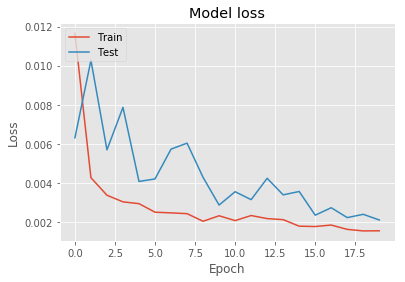

In [28]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Plotting the loss: 
* Here we use the code from the [keras api](https://keras.io/visualization/) to plot the model loss. As we get to the 20th epoch the test loss and train loss are very close and they are minimized. 

In [29]:
# Get the stock prices for 2019 to have our model make the predictions
test_data = test_df['Adj Close'].values
test_data = test_data.reshape(-1,1)
test_data = scaler.transform(test_data)

# Create the data to test our model on:
time_steps = 36
X_test, y_test = create_dataset(test_data, time_steps)

# store the original vals for plotting the predictions 
y_test = y_test.reshape(-1,1)
org_y = scaler.inverse_transform(y_test)

# reshape it [samples, time steps, features]
X_test = np.reshape(X_test, (X_test.shape[0], 36, 1))

# Predict the prices with the model
predicted_y = model.predict(X_test)
predicted_y = scaler.inverse_transform(predicted_y)

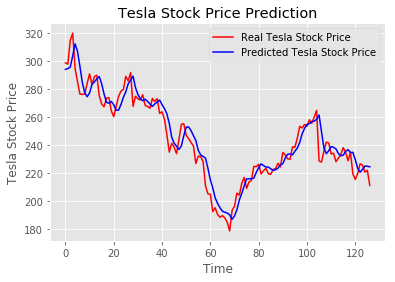

In [30]:
plt.plot(org_y, color = 'red', label = 'Real Tesla Stock Price')
plt.plot(predicted_y, color = 'blue', label = 'Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.show()

## Making the prediction: 
* Here we have our neural network make predictions on the unseen 2019 tesla stock data. 
* We first get our 2019 closing stock prices data from the test dataframe and we transform it into values between 0 and 1. 
* We use our create_dataset function again to turn our data into batches of 36 stock prices. So we give the neural network an X_test array of arrays where each index contains 36 days of closing stock prices. The y_test is what the value should be given the 36 days of prices. 
* We then store the original y values in an org_y variable. We will plot this and compare the values to what our model predicts for the price values. 
* Lastly we reshape it and have the network make the price predictions. 
* As you can see on the prediction graph above, our model performed pretty well and followed the behavior on the whole year of unseen data.

## Conclusion:
* LSTMs are very fascinating and so many useful applications. They allow for accurate predictions on long series of sequential data. I hope you enjoyed this article and I hope you learned something. If you have any questions, concerns, or constructive criticism please reach out to me on [linkedin](https://www.linkedin.com/in/drew-scatterday-415146147/) and check out the code for this project on [github](https://github.com/DrewScatterday). 

## Resources: 
- https://pythonprogramming.net/getting-stock-prices-python-programming-for-finance/
- https://towardsdatascience.com/in-12-minutes-stocks-analysis-with-pandas-and-scikit-learn-a8d8a7b50ee7
- https://www.youtube.com/watch?v=4R2CDbw4g88
- https://medium.com/coinmonks/support-vector-regression-or-svr-8eb3acf6d0ff
- http://www.saedsayad.com/support_vector_machine_reg.htm?source=post_page-----8eb3acf6d0ff----------------------
- https://medium.com/machine-learning-101/chapter-2-svm-support-vector-machine-theory-f0812effc72
- https://www.youtube.com/watch?v=SSu00IRRraY
- http://benalexkeen.com/feature-scaling-with-scikit-learn/
- https://colah.github.io/posts/2015-08-Understanding-LSTMs/
- https://www.youtube.com/watch?v=8HyCNIVRbSU
- https://towardsdatascience.com/playing-with-time-series-data-in-python-959e2485bff8
- https://github.com/krishnaik06/Stock-Price-Prediction-using-Keras-and-Recurrent-Neural-Networ/blob/master/rnn.py